
#Matrix Multiplication
======================
In this tutorial, you will write a 25-lines high-performance FP16 matrix multiplication kernel that achieves performance on par with cuBLAS.
You will specifically learn about:

- Block-level matrix multiplications
- Multi-dimensional pointer arithmetic
- Program re-ordering for improved L2 cache hit rate 
- Automatic performance tuning


In [11]:
# %%
# Motivations
# -------------
# Matrix multiplications are a key building block of most modern high-performance computing systems.
# They are notoriously hard to optimize, hence their implementation is generally done by hardware vendors themselves as part of so-called "kernel libraries" (e.g., cuBLAS).
# Unfortunately, these libraries are often proprietary and cannot be easily customized to accomodate the needs of modern deep learning workloads (e.g., fused activation functions).
# In this tutorial, you will learn how to implement efficient matrix multiplications by yourself with Triton, in a way that is easy to customize and extend.
#
# Roughly speaking, the kernel that we will write will implement the following blocked algorithm:
#
#  .. code-block:: python
#
#    # do in parallel
#    for m in range(0, M, BLOCK_M):
#      # do in parallel
#      for n in range(0, N, BLOCK_N):
#        acc = zeros((BLOCK_M, BLOCK_N), dtype=float32)
#        for k in range(0, K, BLOCK_K):
#          a = A[m : m+BLOCK_M, k : k+BLOCK_K]
#          b = B[k : k+BLOCK_K, n : n+BLOCK_N]
#          acc += dot(a, b)
#        C[m : m+BLOCK_M, n : n+BLOCK_N] = acc;
#
# where each iteration of the doubly-nested for-loop corresponds to a Triton program instance.

# %%
# Compute Kernel
# ----------------
#
# The above algorithm is, actually, fairly straightforward to implement in Triton.
# The main difficulty comes from the computation of the memory locations at which blocks of :code:`A` and :code:`B` must be read in the inner loop. For that, we need multi-dimensional pointer arithmetics.
#
# Pointer Arithmetics
# ~~~~~~~~~~~~~~~~~~~~
#
# For a row-major 2D tensor :code:`X`, the memory location of :code:`X[i, j]` is given by :code:`&X[i, j] = X + i*stride_x_0 + j*stride_x_1`.
# Therefore, blocks of pointers for :code:`A[m : m+BLOCK_M, k:k+BLOCK_K]` and :code:`B[k : k+BLOCK_K, n : n+BLOCK_N]` can be defined in pseudo-code as:
#
#  .. code-block:: python
#
#    &A[m : m+BLOCK_M, k:k+BLOCK_K] =  A + (m : m+BLOCK_M)[:, None]*A.stride(0) + (k : k+BLOCK_K)[None, :]*A.stride(1);
#    &B[k : k+BLOCK_K, n:n+BLOCK_N] =  B + (k : k+BLOCK_K)[:, None]*B.stride(0) + (n : n+BLOCK_N)[None, :]*B.stride(1);
#
# Which means that pointers for blocks of A and B can be initialized (i.e., :code:`k=0`) in Triton as:
#
#  .. code-block:: python
#
#    pid_m = triton.program_id(0)
#    pid_n = triton.program_id(1)
#    rm = pid_m * BLOCK_M + triton.arange(0, BLOCK_M)
#    rn = pid_n * BLOCK_N + triton.arange(0, BLOCK_N)
#    rk = triton.arange(0, BLOCK_K)
#    // pointer for A operand
#    pa = A + (rm[:, None] * stride_a_0 + rk[None, :] * stride_a_1);
#    // pointer for B operand
#    pb = B + (rk[:, None] * stride_b_0 + rn[None, :] * stride_b_1);
#
# And then updated in the inner loop as follows:
#
#  .. code-block:: python
#
#    pa += BLOCK_K * stride_a_1;
#    pb += BLOCK_K * stride_b_0;
#
#
# L2 Cache Optimizations
# ~~~~~~~~~~~~~~~~~~~~~~~~
#
# As mentioned above, each program instance computes an :code:`[BLOCK_M, BLOCK_N]` block of :code:`C`.
# It is important to remember that the order in which these blocks are computed does matter, since it affects the L2 cache hit rate of our program.
# And unfortunately, a simple row-major ordering
#
#  .. code-block:: Python
#
#    pid = triton.program_id(0);
#    grid_m = (M + BLOCK_M - 1) // BLOCK_M;
#    grid_n = (N + BLOCK_N - 1) // BLOCK_N;
#    pid_m = pid / grid_n;
#    pid_n = pid % grid_n;
#
# is just not going to cut it.
#
# One possible solution is to launch blocks in an order that promotes data reuse.
# This can be done by 'super-grouping' blocks in groups of :code:`GROUP_M` rows before switching to the next column:
#
#  .. code-block:: python
#
#    pid = triton.program_id(0);
#    width = GROUP_M * grid_n;
#    group_id = pid // width;
#    # we need to handle the case where M % (GROUP_M*BLOCK_M) != 0
#    group_size = min(grid_m - group_id * GROUP_M, GROUP_M);
#    pid_m = group_id * GROUP_M + (pid % group_size);
#    pid_n = (pid % width) // (group_size);
#
# In practice, this can improve the performance of our matrix multiplication kernel by >10\% on some hardware architecture (e.g., 220 to 245 TFLOPS on A100).
#


In [12]:
# import streamlit as st
import torch
import triton
import triton.language as tl



 - :code:`triton.jit`'ed functions can be auto-tuned by using the `triton.autotune` decorator, which consumes:
 - A list of :code:`triton.Config` objects that define different configurations of meta-parameters (e.g., BLOCK_M) and compilation options (e.g., num_warps) to try
 - A autotuning *key* whose change in values will trigger evaluation of all the provided configs


In [13]:
@triton.autotune(
    configs=[
        triton.Config({'BLOCK_M': 128, 'BLOCK_N': 256, 'BLOCK_K': 32, 'GROUP_M': 8}, num_stages=3, num_warps=8),
        triton.Config({'BLOCK_M': 256, 'BLOCK_N': 128, 'BLOCK_K': 32, 'GROUP_M': 8}, num_stages=3, num_warps=8),
        triton.Config({'BLOCK_M': 256, 'BLOCK_N': 64,  'BLOCK_K': 32, 'GROUP_M': 8}, num_stages=4, num_warps=4),
        triton.Config({'BLOCK_M': 64 , 'BLOCK_N': 256, 'BLOCK_K': 32, 'GROUP_M': 8}, num_stages=4, num_warps=4),\
        triton.Config({'BLOCK_M': 128, 'BLOCK_N': 128, 'BLOCK_K': 32, 'GROUP_M': 8}, num_stages=4, num_warps=4),\
        triton.Config({'BLOCK_M': 128, 'BLOCK_N': 64 , 'BLOCK_K': 32, 'GROUP_M': 8}, num_stages=4, num_warps=4),\
        triton.Config({'BLOCK_M': 64 , 'BLOCK_N': 128, 'BLOCK_K': 32, 'GROUP_M': 8}, num_stages=4, num_warps=4),
        triton.Config({'BLOCK_M': 128, 'BLOCK_N': 32 , 'BLOCK_K': 32, 'GROUP_M': 8}, num_stages=4, num_warps=4),\
        triton.Config({'BLOCK_M': 64 , 'BLOCK_N': 32 , 'BLOCK_K': 32, 'GROUP_M': 8}, num_stages=5, num_warps=2),\
        triton.Config({'BLOCK_M': 32 , 'BLOCK_N': 64 , 'BLOCK_K': 32, 'GROUP_M': 8}, num_stages=5, num_warps=2),
        #triton.Config({'BLOCK_M': 64, 'BLOCK_N': 128, 'BLOCK_K': 32, 'GROUP_M': 8}, num_warps=4),
    ],
    key=['M', 'N', 'K'],
)

@triton.jit
def _matmul(A, B, C, 
            M, N, K, 
            stride_am, stride_ak, 
            stride_bk, stride_bn, 
            stride_cm, stride_cn, 
            **META):
    # extract meta-parameters
    BLOCK_M = META['BLOCK_M']
    BLOCK_N = META['BLOCK_N']
    BLOCK_K = META['BLOCK_K']
    GROUP_M = 8
    # matrix multiplication
    pid = tl.program_id(0)
    grid_m = (M + BLOCK_M - 1) // BLOCK_M
    grid_n = (N + BLOCK_N - 1) // BLOCK_N
    # re-order program ID for better L2 performance
    width = GROUP_M * grid_n
    group_id = pid // width
    group_size = min(grid_m - group_id * GROUP_M, GROUP_M)
    pid_m = group_id * GROUP_M + (pid % group_size)
    pid_n = (pid % width) // (group_size)
    # do matrix multiplication
    rm = pid_m * BLOCK_M + tl.arange(0, BLOCK_M)
    rn = pid_n * BLOCK_N + tl.arange(0, BLOCK_N)
    rk = tl.arange(0, BLOCK_K)
    A = A + (rm[:, None] * stride_am + rk[None, :] * stride_ak)
    B = B + (rk[:, None] * stride_bk + rn[None, :] * stride_bn)
    acc = tl.zeros((BLOCK_M, BLOCK_N), dtype=tl.float32)
    for k in range(K, 0, -BLOCK_K):
        a = tl.load(A)
        b = tl.load(B)
        acc += tl.dot(a, b)
        A += BLOCK_K * stride_ak
        B += BLOCK_K * stride_bk
    # triton can accept arbitrary activation function
    # via metaparameters!
    if META['ACTIVATION']:
        acc = META['ACTIVATION'](acc)
    # rematerialize rm and rn to save registers
    rm = pid_m * BLOCK_M + tl.arange(0, BLOCK_M)
    rn = pid_n * BLOCK_N + tl.arange(0, BLOCK_N)
    C = C + (rm[:, None] * stride_cm + rn[None, :] * stride_cn)
    mask = (rm[:, None] < M) & (rn[None, :] < N)
    tl.store(C, acc, mask=mask)



In [14]:
# we can fuse `leaky_relu` by providing it as an `ACTIVATION` meta-parameter in `_matmul`
@triton.jit
def leaky_relu(x):
    return tl.where(x >= 0, x, 0.01*x)


In [15]:
def matmul(a, b, activation=None):
    # checks constraints
    assert a.shape[1] == b.shape[0], "incompatible dimensions"
    assert a.is_contiguous(), "matrix A must be contiguous"
    assert b.is_contiguous(), "matrix B must be contiguous"
    M, K = a.shape
    _, N = b.shape
    # allocates output
    c = torch.empty((M, N), device=a.device, dtype=a.dtype)
    # launch kernel
    grid = lambda META: (triton.cdiv(M, META['BLOCK_M']) * triton.cdiv(N, META['BLOCK_N']), )
    pgm = _matmul[grid](
        a, b, c, M, N, K, \
        a.stride(0), a.stride(1), b.stride(0), b.stride(1), c.stride(0), c.stride(1),\
#         BLOCK_M= 128, BLOCK_N = 64, BLOCK_K = 32, GROUP_M = 8,\
        ACTIVATION = activation
    )
    # done; return the output tensor
    return c


In [16]:
# %%
# Unit Test
# -----------
#
# We can test our custom matrix multiplication operation against a native torch implementation (i.e., cuBLAS)

torch.manual_seed(0)
a = torch.randn((512, 512), device='cuda', dtype=torch.float16)
b = torch.randn((512, 512), device='cuda', dtype=torch.float16)
c_0 = matmul(a, b, activation=None)
c_1 = torch.matmul(a, b)
print("Matmul due to triton\n {}\n".format(c_0))
print("Matmul due to torch\n {}".format(c_1))
print(triton.testing.allclose(c_0, c_1))


Matmul due to triton
 tensor([[ 13.3203,  17.2656,  24.0156,  ..., -22.6562,  15.6641,  -5.0430],
        [ -9.3203,  26.3281,  -6.9453,  ...,  31.9375,  23.4062,  18.1094],
        [-11.9609,  44.8750, -22.7812,  ...,  20.9844, -56.5000,  10.3125],
        ...,
        [-11.0703,  -1.9775, -10.2891,  ...,  26.0000, -61.7812, -13.1172],
        [ 23.5938, -21.3281, -34.5938,  ...,  47.5938, -25.0469,  -0.1646],
        [-22.6406,  16.5156,   8.3828,  ...,  30.6250,  31.6719,  16.9688]],
       device='cuda:0', dtype=torch.float16)

Matmul due to torch
 tensor([[ 13.3281,  17.2656,  24.0156,  ..., -22.6562,  15.6641,  -5.0430],
        [ -9.3203,  26.3438,  -6.9453,  ...,  31.9375,  23.4062,  18.1094],
        [-11.9609,  44.8750, -22.7812,  ...,  20.9844, -56.5000,  10.3203],
        ...,
        [-11.0703,  -1.9775, -10.2969,  ...,  26.0000, -61.7812, -13.1250],
        [ 23.5938, -21.3281, -34.5938,  ...,  47.5938, -25.0469,  -0.1637],
        [-22.6406,  16.5156,   8.3828,  ...,  30

In [17]:
# %%
# Benchmark
# --------------
#
# Square Matrix Performance
# ~~~~~~~~~~~~~~~~~~~~~~~~~~
# We can now compare the performance of our kernel against that of cuBLAS. Here we focus on square matrices, but feel free to arrange this script as you wish to benchmark any other matrix shape.



In [18]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['M', 'N', 'K'],  # argument names to use as an x-axis for the plot
        x_vals=[128 * i for i in range(1, 33)],  # different possible values for `x_name`
        line_arg='provider',  # argument name whose value corresponds to a different line in the plot
        line_vals=['cublas', 'cublas + relu', 'triton', 'triton + relu'],  # possible values for `line_arg``
        line_names=["cuBLAS", "cuBLAS (+ torch.nn.LeakyReLU)", "Triton", "Triton (+ LeakyReLU)"],  # label name for the lines
        styles=[('green', '-'), ('green', '--'), ('blue', '-'), ('blue', '--')],  # line styles
        ylabel="TFLOPS",  # label name for the y-axis
        plot_name="matmul-performance",  # name for the plot. Used also as a file name for saving the plot.
        args={}
    )
)
def benchmark(M, N, K, provider):
    a = torch.randn((M, K), device='cuda', dtype=torch.float16)
    b = torch.randn((K, N), device='cuda', dtype=torch.float16)
    if provider == 'cublas':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: torch.matmul(a, b))
    if provider == 'triton':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: matmul(a, b))
    if provider == 'cublas + relu':
        torch_relu = torch.nn.ReLU(inplace=True)
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: torch_relu(torch.matmul(a, b)))
    if provider == 'triton + relu':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: matmul(a, b, activation=leaky_relu))
    perf = lambda ms: 2 * M * N * K * 1e-12 / (ms * 1e-3)
    return perf(ms), perf(max_ms), perf(min_ms)


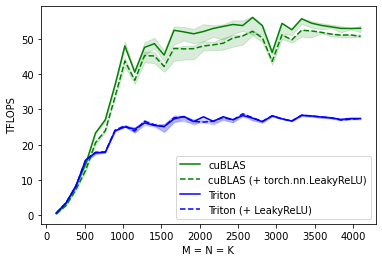

matmul-performance:
         M     cuBLAS  cuBLAS (+ torch.nn.LeakyReLU)     Triton  \
0    128.0   0.510008                       0.409600   0.618264   
1    256.0   3.276800                       2.752168   3.542486   
2    384.0   8.366298                       7.207625   8.192000   
3    512.0  14.438224                      12.768049  15.650388   
4    640.0  23.272727                      20.557089  17.655172   
5    768.0  27.040640                      23.952243  17.839668   
6    896.0  36.941411                      33.600671  23.951890   
7   1024.0  47.934905                      43.690665  25.012622   
8   1152.0  40.539452                      38.235891  24.400278   
9   1280.0  47.541530                      45.197242  26.162076   
10  1408.0  48.595217                      45.125925  25.434733   
11  1536.0  45.371078                      42.130286  25.129526   
12  1664.0  52.385879                      47.246133  27.272013   
13  1792.0  51.936689                     

In [19]:
benchmark.run(show_plots=True, print_data=True)
